# Support Vector Machines

Readings:

Geron, ch. 5

In [72]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [73]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### A **Support Vector Machine (SVM)** is a very powerful and versatile Machine Learning model.

- Capable of performing linear or nonlinear classification, regression, and even
outlier detection.
- It is one of the most popular models in Machine Learning, and anyone interested in Machine Learning should have it in their toolbox.
- SVMs are particularly well suited for classification of complex but small- or medium-sized datasets.

### It is easier to introduce SVMs using some pictures

In [74]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=1000)
svm_clf.fit(X, y)

SVC(C=1000, kernel='linear')

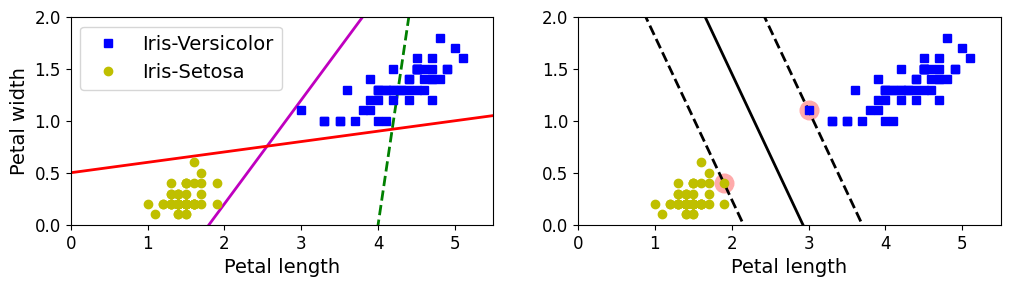

In [75]:
# Bad models
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5 * x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    # First we get the SVM fitted decision boundary
    w = svm_clf.coef_[0]      # linear kernel
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]    # Margin!
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_    # Support Vectors!
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

plt.figure(figsize=(12,2.7))

plt.subplot(121);
plt.plot(x0, pred_1, "g--", linewidth=2);
plt.plot(x0, pred_2, "m-", linewidth=2);
plt.plot(x0, pred_3, "r-", linewidth=2);
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor");
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa");
plt.xlabel("Petal length", fontsize=14);
plt.ylabel("Petal width", fontsize=14);
plt.legend(loc="upper left", fontsize=14);
plt.axis([0, 5.5, 0, 2]);

plt.subplot(122);
plot_svc_decision_boundary(svm_clf, 0, 5.5);
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs");
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo");
plt.xlabel("Petal length", fontsize=14);
plt.axis([0, 5.5, 0, 2]);

plt.show();

#### The two Iris classes can clearly be separated easily with a straight line (they are linearly separable).

- The left plot shows the decision boundaries of three possible linear classifiers.
- The model whose decision boundary is represented by the dashed line is so bad that it does not even separate the classes properly.
- The other two models work perfectly on this training set, **but their decision boundaries come so close to the instances that these models will probably not perform as well on new instances**.
- In contrast, the solid line in the plot on the right represents the decision boundary of an SVM classifier

#### The SVM line not only separates the two classes but also stays as far away from the closest training instances as possible.

- You can think of an SVM classifier as fitting the widest possible street (represented by the parallel dashed lines) between the classes.
- This is called **large margin classification**.
- Notice that adding more training instances “off the street” will not affect the decision
boundary at all: it is fully determined (or “supported”) by the *instances located on the
edge of the street*.
- These instances are called the **support vectors**.

### SVMs are sensitive to the feature scales

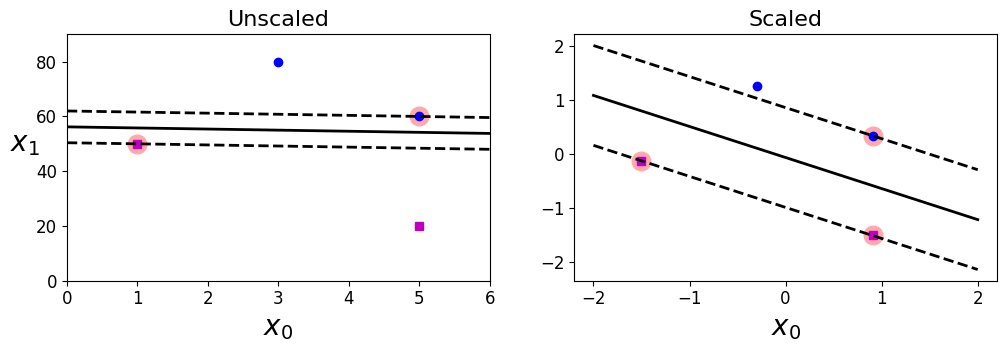

In [76]:
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100)
svm_clf.fit(Xs, ys)

plt.figure(figsize=(12,3.2));
plt.subplot(121);
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo");
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms");
plot_svc_decision_boundary(svm_clf, 0, 6);
plt.xlabel("$x_0$", fontsize=20);
plt.ylabel("$x_1$  ", fontsize=20, rotation=0);
plt.title("Unscaled", fontsize=16);
plt.axis([0, 6, 0, 90]);

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf.fit(X_scaled, ys)

plt.subplot(122);
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo");
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms");
plot_svc_decision_boundary(svm_clf, -2, 2);
plt.xlabel("$x_0$", fontsize=20);
plt.title("Scaled", fontsize=16);


- On the left plot, the vertical scale is much larger than the horizontal scale, so the widest possible street is close to horizontal.

- After feature scaling using `StandardScaler`, the decision boundary looks much better (on the right plot).

### Soft Margin Classification

- If we strictly impose that all instances be off the street and on the right side, this is
called **hard margin classification**.
- There are two main issues with hard margin classification.
    - it only works if the data is linearly separable, 
    - it is quite sensitive to outliers

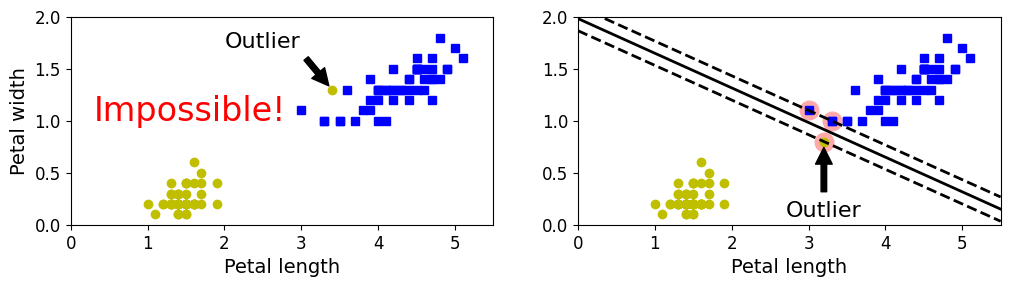

In [77]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
# Two new datasets
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0) # not linearly separable
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)

Xo2 = np.concatenate([X, X_outliers[1:]], axis=0) # very close to the other class
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

plt.figure(figsize=(12,2.7));

plt.subplot(121);
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs");
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo");
plt.text(0.3, 1.0, "Impossible!", fontsize=24, color="red");
plt.xlabel("Petal length", fontsize=14);
plt.ylabel("Petal width", fontsize=14);
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            );
plt.axis([0, 5.5, 0, 2]);

plt.subplot(122);
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs");
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo");
plot_svc_decision_boundary(svm_clf2, 0, 5.5);
plt.xlabel("Petal length", fontsize=14);
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            );
plt.axis([0, 5.5, 0, 2]);

plt.show();

- On the left, it is impossible to find a hard margin
- On the right, the decision boundary ends up very different from the one without the outlier, and it will probably not generalize as well.

- To avoid these issues it is preferable to use a more flexible model.
- The objective is to find a good balance between keeping the street as large as possible and limiting the **margin violations** (i.e., instances that end up in the middle of the street or even on the wrong side).
- This is called **soft margin classification**

#### In Scikit-Learn’s SVM classes, you can control this balance using the *C* hyperparameter
- a smaller $C$ value leads to a wider street but more margin violations

The following Scikit-Learn code loads the iris dataset, scales the features, and then
trains a linear SVM model using the `LinearSVC` class with $C = 1$ and the **hinge loss function** to detect Iris-Virginica flowers


In [78]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris-Virginica

svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
    ])

svm_clf.fit(X, y)

# As usual, we can produce out of sample predictions
svm_clf.predict([[5.5, 1.7]])    

# Unlike Logistic Regression classifiers,
# SVM classifiers do not output probabilities for each class.

c:\Users\310\Desktop\Progects_Py\env\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge', random_state=42))])

array([1.])

In [79]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42, tol=0.001)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42, tol=0.001)

scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

c:\Users\310\Desktop\Progects_Py\env\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=1, loss='hinge', random_state=42, tol=0.001))])

c:\Users\310\Desktop\Progects_Py\env\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=100, loss='hinge', random_state=42, tol=0.001))])

In [80]:
svm_clf1.intercept_
svm_clf1.coef_
x_new = np.array([1, 1])
svm_clf1.decision_function([x_new])  == \
            svm_clf1.intercept_ + svm_clf1.coef_.dot(x_new)
#scaler.mean_
#scaler.scale_

array([-2.50496506])

array([[1.63302019, 2.38747444]])

array([ True])

In [81]:
# Convert to unscaled parameters
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])
[b1, w1]
# Find support vectors 
# LinearSVC does not do this automatically/ does not have a support_vectors_ attribute
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

[array([-9.76214194]), array([0.92816666, 3.14268476])]

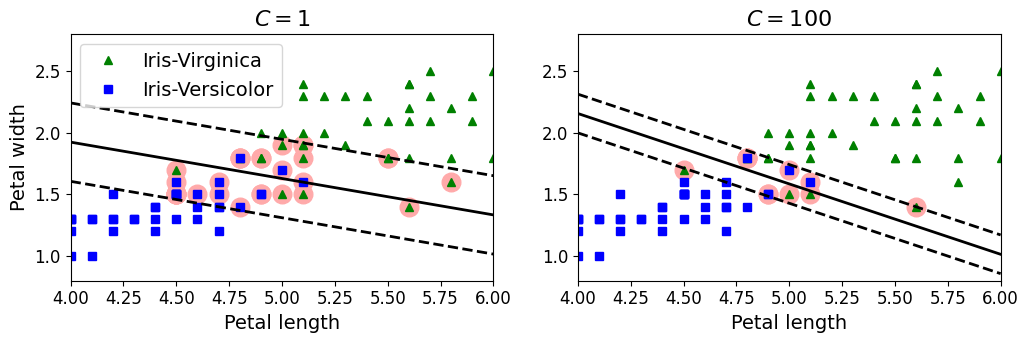

In [82]:
plt.figure(figsize=(12,3.2))
plt.subplot(121)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris-Virginica");
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris-Versicolor");
plot_svc_decision_boundary(svm_clf1, 4, 6);
plt.xlabel("Petal length", fontsize=14);
plt.ylabel("Petal width", fontsize=14);
plt.legend(loc="upper left", fontsize=14);
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16);
plt.axis([4, 6, 0.8, 2.8]);

plt.subplot(122)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^");
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs");
plot_svc_decision_boundary(svm_clf2, 4, 6);
plt.xlabel("Petal length", fontsize=14);
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16);
plt.axis([4, 6, 0.8, 2.8]);

- On the left, using a low $C$ value the margin is quite large, but many instances end up on the street.
- On the right, using a high $C$ value the classifier makes fewer margin violations but ends up with a smaller margin. 
- However, it seems likely that the first classifier will generalize better: in fact even on this training set it makes fewer prediction errors

### Nonlinear SVM Classification

- Although linear SVM classifiers are efficient and work surprisingly well in many
cases, many datasets are not even close to being linearly separable.
- One approach to handling nonlinear datasets is to add more features, such as polynomial features.

For example, the following dataset is not linearly separable but if you add a second feature $x_2 = (x_1)^2$, the resulting 2D dataset is perfectly linearly separable.

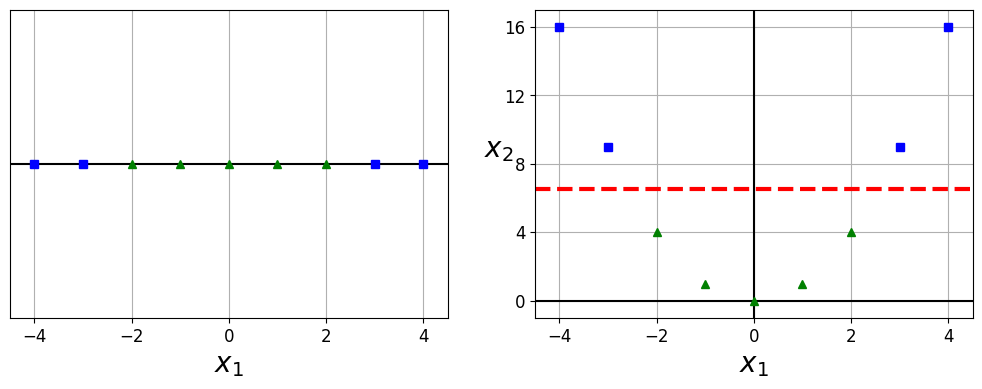

In [83]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(11, 4))

plt.subplot(121);
plt.grid(True, which='both');
plt.axhline(y=0, color='k');
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs");
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^");
plt.gca().get_yaxis().set_ticks([]);
plt.xlabel(r"$x_1$", fontsize=20);
plt.axis([-4.5, 4.5, -0.2, 0.2]);

plt.subplot(122)
plt.grid(True, which='both');
plt.axhline(y=0, color='k');
plt.axvline(x=0, color='k');
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs");
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^");
plt.xlabel(r"$x_1$", fontsize=20);
plt.ylabel(r"$x_2$", fontsize=20, rotation=0);
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16]);
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3);    # separation 
plt.axis([-4.5, 4.5, -1, 17]);

plt.subplots_adjust(right=1);

plt.show();

- To implement this idea using Scikit-Learn, you can create a `Pipeline` containing a
`PolynomialFeatures` transformer, followed by a `StandardScaler` and a `LinearSVC`.


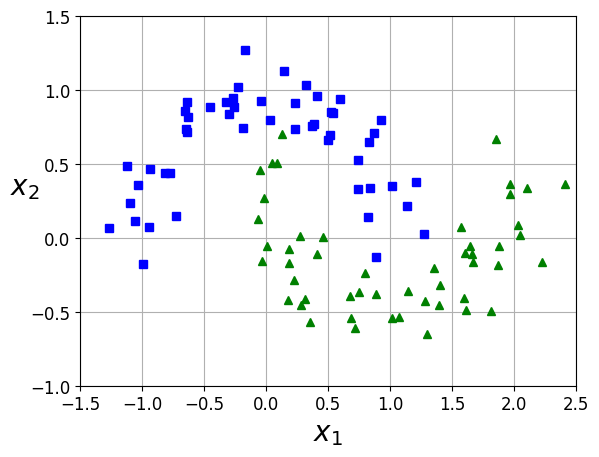

In [84]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [85]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge",
                              random_state=42, tol=0.001, max_iter=10000))
    ])
polynomial_svm_clf_2 = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge",
                              random_state=42, tol=0.001, max_iter=10000))
    ])

polynomial_svm_clf.fit(X, y)
polynomial_svm_clf_2.fit(X, y)

c:\Users\310\Desktop\Progects_Py\env\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Pipeline(steps=[('poly_features', PolynomialFeatures()),
                ('scaler', StandardScaler()),
                ('svm_clf',
                 LinearSVC(C=10, loss='hinge', max_iter=10000, random_state=42,
                           tol=0.001))])

c:\Users\310\Desktop\Progects_Py\env\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=10)),
                ('scaler', StandardScaler()),
                ('svm_clf',
                 LinearSVC(C=10, loss='hinge', max_iter=10000, random_state=42,
                           tol=0.001))])

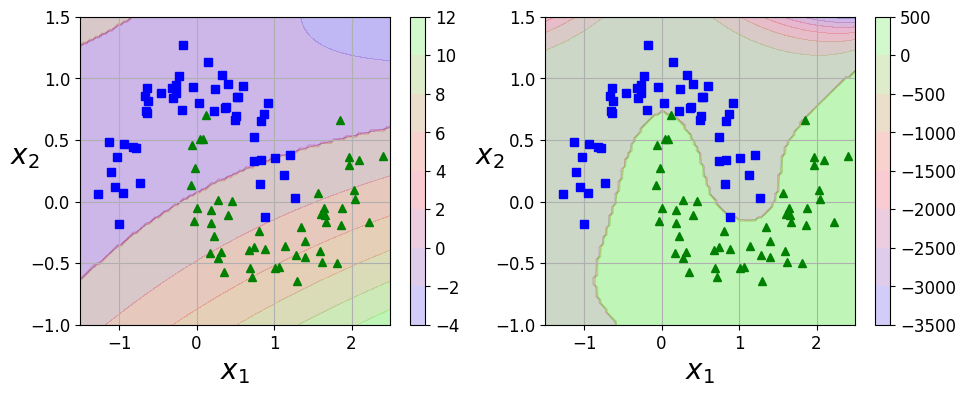

In [86]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.1)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.2)
    plt.colorbar()

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5]);
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5]);

plt.subplot(122)
plot_predictions(polynomial_svm_clf_2, [-1.5, 2.5, -1, 1.5]);
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5]);

plt.show();

### Polynomial Kernel

- Adding polynomial features is simple to implement and can work great with all sorts
of Machine Learning algorithms (not just SVMs)
- But at a low polynomial degree it cannot deal with very complex datasets, and with a high polynomial degree it creates **a huge number of features**, making the model too slow.

- Fortunately, when using SVMs you can apply an almost miraculous mathematical
technique called *the kernel trick*.
- The kernel trick makes it possible to get the same result as if you added many polynomial features, even with very highdegree polynomials, without actually having to add them. So there is no combinatorial explosion of the number of features since you don’t actually add any features. 
- This trick is implemented by the `SVC` class.

In [87]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

In [88]:
poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=100, degree=10, kernel='poly'))])

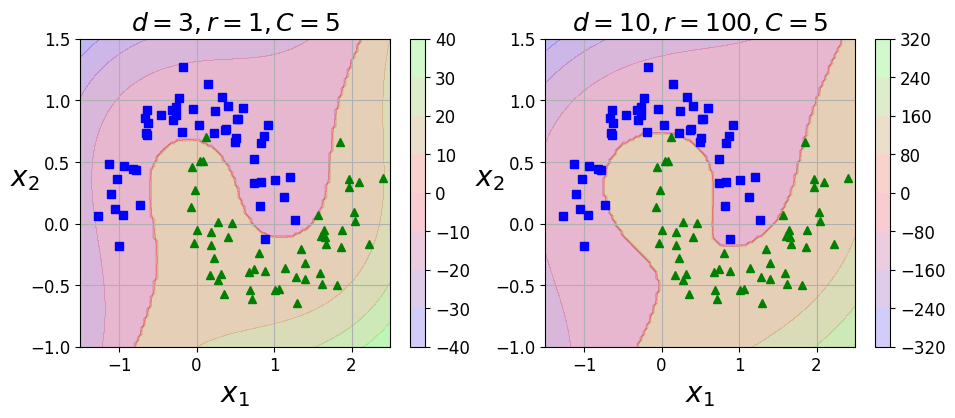

In [89]:
plt.figure(figsize=(11, 4))

plt.subplot(121);
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5]);
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5]);
plt.title(r"$d=3, r=1, C=5$", fontsize=18);

plt.subplot(122);
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.5, -1, 1.5]);
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5]);
plt.title(r"$d=10, r=100, C=5$", fontsize=18);

plt.show();

- On the left, an SVM classifier using a 3rd-degree polynomial kernel.
- On the right is another SVM classifier using a 10thdegree polynomial kernel.

The hyperparameter `coef0` controls how much the model is influenced by high-degree
polynomials versus low-degree polynomials.

- A common approach to find the right hyperparameter values is to
use *grid search*. It is often faster to first do a very
coarse grid search, then a finer grid search around the best values
found.

### Adding Similarity Features

- Another technique to tackle nonlinear problems is to add features computed using a
**similarity function** that measures how much each instance resembles a particular
landmark.

- For example, let’s take the one-dimensional dataset discussed earlier and
add two landmarks to it at $x_1 = –2$ and $x_1 = 1$.
- Next, let’s define the similarity function to be the **Gaussian Radial Basis Function (RBF)** with $γ = 0.3$.

$$\phi_\gamma(\mathbf{x}, \ell)=\exp\left( -\gamma||\mathbf{x}-\ell||^2\right)$$

It is a bell-shaped function varying from 0 (very far away from the landmark) to 1 (at the landmark).

For example, let’s look at the instance $x_1 = –1$: it is located at a distance of $1$ from the first landmark, and $2$
from the second landmark. Therefore its new features are $x_2 = \exp(–0.3×12)≈ 0.74$ and $x_3=\exp(–0.3×22)≈0.30$.

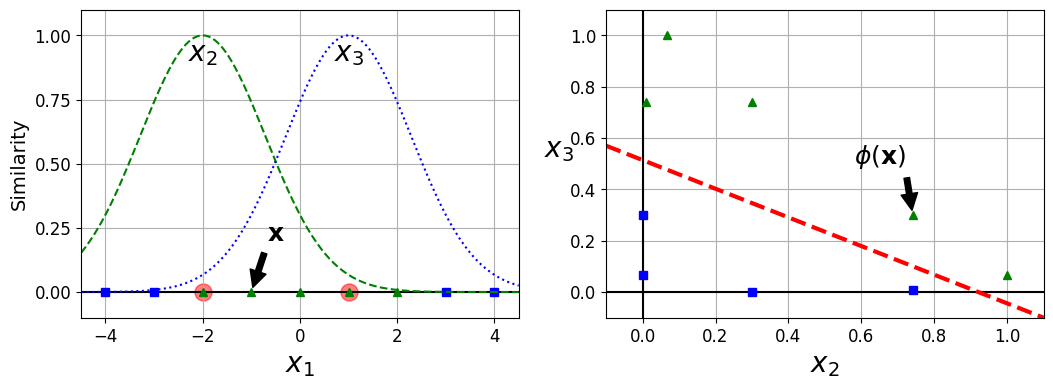

In [90]:

def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

# Example
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.grid(True, which='both');
plt.axhline(y=0, color='k');
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red");   # landmarks
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs");
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^");
plt.plot(x1s, x2s, "g--");   # feature generating function landmark 1
plt.plot(x1s, x3s, "b:");     # feature generating function landmark 2
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1]);
plt.xlabel(r"$x_1$", fontsize=20);
plt.ylabel(r"Similarity", fontsize=14);
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            );
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20);
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20);
plt.axis([-4.5, 4.5, -0.1, 1.1]);

plt.subplot(122);
plt.grid(True, which='both');
plt.axhline(y=0, color='k');
plt.axvline(x=0, color='k');
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs");
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^");
plt.xlabel(r"$x_2$", fontsize=20);
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0);
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            );
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3);
plt.axis([-0.1, 1.1, -0.1, 1.1]);
    
plt.subplots_adjust(right=1);

plt.show();

#### How to select the landmarks?

- The simplest approach is to create a landmark at the location of each and every instance in the dataset. 
- This creates many dimensions and thus increases the chances that the transformed training set will be linearly separable.
- The downside is that a training set with $m$ instances and $n$ features gets transformed into a training set with $m$ instances and $m$ features (assuming you drop the original features).
- If your training set is very large, you end up with an equally large number of features.

### Gaussian RBF Kernel

- Just like the polynomial features method, the similarity features method can be useful
with any Machine Learning algorithm, but it may be computationally expensive to
compute all the additional features, especially on large training sets.
- However, once again the *kernel trick* does its SVM magic: it makes it possible to obtain a similar result as if you had added many similarity features, without actually having to add them.

In [91]:
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

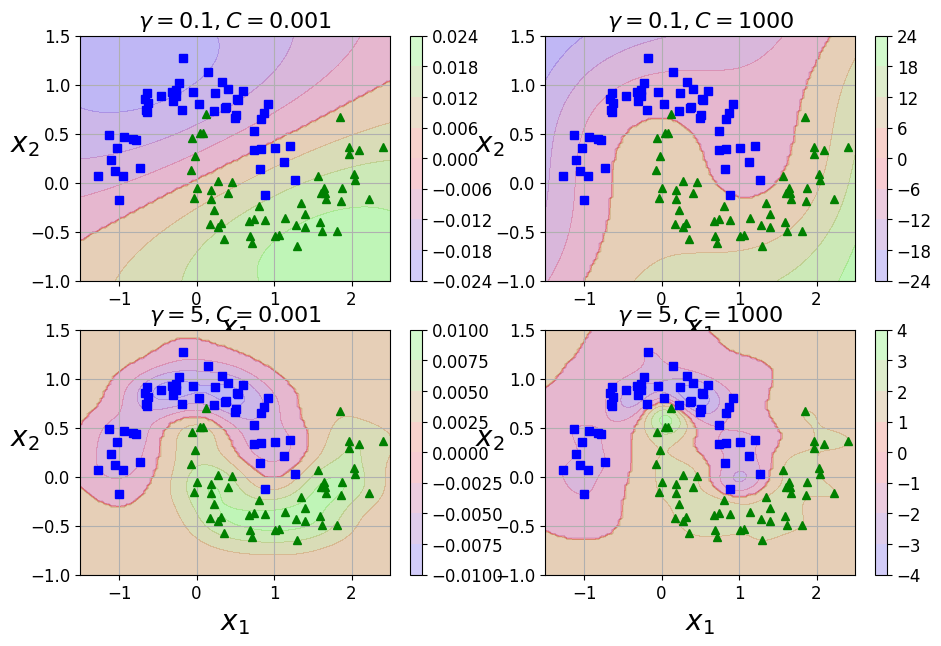

In [92]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

plt.figure(figsize=(11, 7))

for i, svm_clf in enumerate(svm_clfs):
    plt.subplot(221 + i);
    plot_predictions(svm_clf, [-1.5, 2.5, -1, 1.5]);
    plot_dataset(X, y, [-1.5, 2.5, -1, 1.5]);
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16);

plt.show();

- Increasing $\gamma$ makes the bell-shape curve narrower, and as a result each instance’s range of influence is smaller: the decision boundary ends up being more irregular, wiggling around individual instances.
- Conversely, a small $\gamma$ value makes the bell-shaped curve wider, so instances have a larger range of influence, and the decision boundary ends up smoother.

- So $γ$ acts like a regularization hyperparameter: if your model is overfitting, you should reduce it, and if it is underfitting, you should increase it (similar to the $C$ hyperparameter).

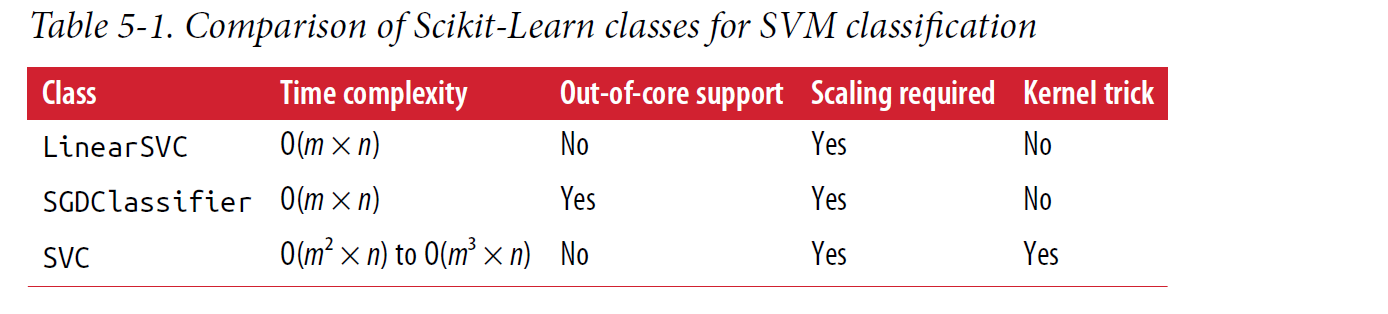

### SVM Regression

- The SVM algorithm is quite versatile: not only does it support
linear and nonlinear classification, but it also supports linear and nonlinear
regression.

- The trick is to reverse the objective: instead of trying to fit the largest possible
street between two classes while limiting margin violations, **SVM Regression
tries to fit as many instances as possible on the street while limiting margin violations**
(i.e., instances off the street).
- The width of the street is controlled by a hyperparameter $ϵ$.

- Adding more training instances within the margin does not affect the model’s predictions;
thus, the model is said to be ϵ-insensitive.
- You can use Scikit-Learn’s `LinearSVR` class to perform linear SVM Regression

In [93]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [94]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

c:\Users\310\Desktop\Progects_Py\env\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVR(epsilon=1.5, random_state=42)

In [95]:
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

c:\Users\310\Desktop\Progects_Py\env\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVR(epsilon=1.5, random_state=42)

c:\Users\310\Desktop\Progects_Py\env\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVR(epsilon=0.5, random_state=42)

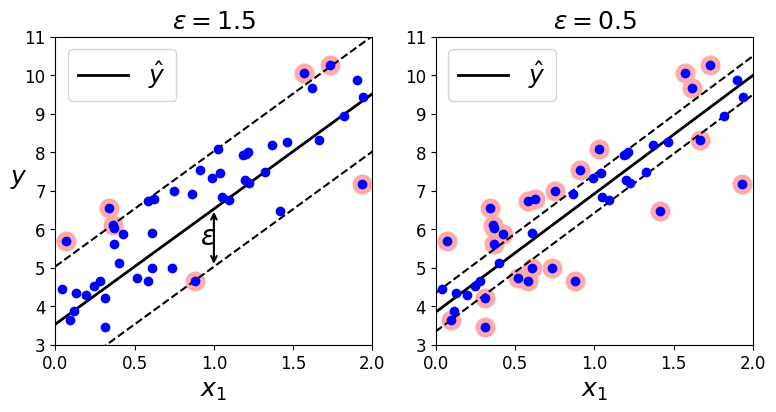

In [96]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$");
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--");
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--");
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA');
    plt.plot(X, y, "bo");
    plt.xlabel(r"$x_1$", fontsize=18);
    plt.legend(loc="upper left", fontsize=18);
    plt.axis(axes);

plt.figure(figsize=(9, 4))
plt.subplot(121)
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11]);
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18);
plt.ylabel(r"$y$", fontsize=18, rotation=0);
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    );
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20);
plt.subplot(122);
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11]);
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18);
plt.show();

#### To tackle nonlinear regression tasks, you can use a kernelized SVM model

In [97]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

In [98]:
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="scale")
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

SVR(C=100, degree=2, kernel='poly')

SVR(C=0.01, degree=2, kernel='poly')

The `SVR` class is the regression equivalent of the `SVC` class, and the `LinearSVR` class is the regression equivalent of the `LinearSVC` class.

The LinearSVR class scales linearly with the size of the training set (just like the LinearSVC class), while the SVR class gets much too slow when the training set grows large (just like the SVC class).

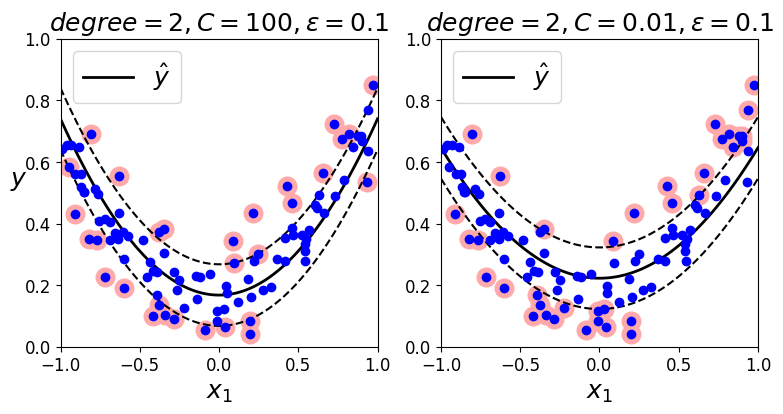

In [99]:
plt.figure(figsize=(9, 4))
plt.subplot(121)
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1]);
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18);
plt.ylabel(r"$y$", fontsize=18, rotation=0);
plt.subplot(122)
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1]);
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18);
plt.show();

- The figure shows SVM Regression on a random quadratic training set, using a
2nd-degree polynomial kernel.
- There is little regularization on the left plot (i.e., a large
$C$ value), and much more regularization on the right plot (i.e., a small $C$ value).

## Under the Hood

- Notation: the bias term will be called $b$ and the feature weights vector will be called $\mathbf w$.  No bias feature will be added to the input feature vectors.

#### Decision Function and Predictions

- The linear SVM classifier model predicts the class of a new instance $\mathbf x$ by simply computing the *decision function*: $h(\mathbf x) = \mathbf w^T \mathbf x + b = w_1 x_1 + ⋯ + w_n x_n + b$.
- if the result is positive, the predicted class $ŷ$ is the positive class ($1$), or else it is the negative class (which now we'll label as $-1$).

$$
\hat{y} = \begin{cases}
            -1   & \text{ if } \mathbf w^T \mathbf x + b < 0,\\
            1   & \text{ if } \mathbf w^T \mathbf x + b \ge 0.\\
     \end{cases}
$$

In [100]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris-Virginica

AttributeError: 'Axes' object has no attribute 'plot_surface'

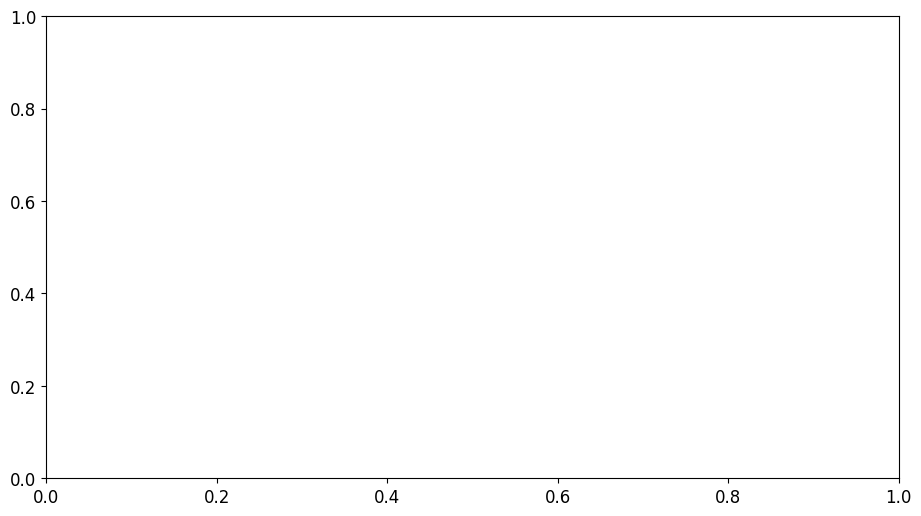

In [106]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3D_decision_function(ax, w, b, x1_lim=[4, 6], x2_lim=[0.8, 2.8]):
    x1_in_bounds = (X[:, 0] > x1_lim[0]) & (X[:, 0] < x1_lim[1])
    X_crop = X[x1_in_bounds]
    y_crop = y[x1_in_bounds]
    x1s = np.linspace(x1_lim[0], x1_lim[1], 20)
    x2s = np.linspace(x2_lim[0], x2_lim[1], 20)
    x1, x2 = np.meshgrid(x1s, x2s)
    xs = np.c_[x1.ravel(), x2.ravel()]
    df = (xs.dot(w) + b).reshape(x1.shape)    # decision function
    m = 1 / np.linalg.norm(w)                  # margin size
    boundary_x2s = -x1s*(w[0]/w[1])-b/w[1]     # decision boundary
    
    margin_x2s_1 = -x1s*(w[0]/w[1])-(b-1)/w[1]
    margin_x2s_2 = -x1s*(w[0]/w[1])-(b+1)/w[1]
    ax.plot_surface(x1s, x2, np.zeros_like(x1), color="y", alpha=0.2, cstride=100, rstride=100, plot_surface='3d')
    ax.plot(x1s, boundary_x2s, 0, "k-", linewidth=2, label=r"$h=0$")
    ax.plot(x1s, margin_x2s_1, 0, "k--", linewidth=2, label=r"$h=\pm 1$")
    ax.plot(x1s, margin_x2s_2, 0, "k--", linewidth=2)
    ax.plot(X_crop[:, 0][y_crop==1], X_crop[:, 1][y_crop==1], 0, "g^")
    ax.plot_wireframe(x1, x2, df, alpha=0.3, color="k")
    ax.plot(X_crop[:, 0][y_crop==0], X_crop[:, 1][y_crop==0], 0, "bs")
    ax.axis(x1_lim + x2_lim)
    ax.text(4.5, 2.5, 3.8, "Decision function $h$", fontsize=16)
    ax.set_xlabel(r"Petal length", fontsize=16, labelpad=10)
    ax.set_ylabel(r"Petal width", fontsize=16, labelpad=10)
    ax.set_zlabel(r"$h = \mathbf{w}^T \mathbf{x} + b$", fontsize=18, labelpad=5)
    ax.legend(loc="upper left", fontsize=16)

fig = plt.figure(figsize=(11, 6))
ax1 = fig.gca()
w = svm_clf2.coef_[0]
b = svm_clf2.intercept_[0]
plot_3D_decision_function(ax1, w=w, b=b)

plt.show()

- This figure shows the decision function that corresponds to the model we estimated above
- It is a two-dimensional plane since this dataset has two features (petal width and petal length).
- The decision boundary is the set of points where the decision function is equal to 0: it is the intersection of two planes, which is a straight line.
- More generally, when there are $n$ features, the decision function is an n-dimensional hyperplane, and the decision boundary is an (n – 1)-dimensional hyperplane.
- The dashed lines represent the points where the decision function is equal to 1 or –1: they are parallel and at equal distance to the decision boundary, forming a margin around it. 
- Training a linear SVM classifier means finding the value of $w$ and $b$ that make this margin as wide as possible while avoiding margin violations (hard margin) or limiting them (soft margin).

### Training objective function

- Assume the classes are **linearly separable**, so we can find an hyperplane that creates the biggest **margin** between the training points for the two clases:

$$\max_{\mathbf w, b, ||\mathbf w||=1} M \\
    \text{subject to} \quad 
    y^{(i)}(\mathbf w^T \mathbf x^{(i)} + b)\ge M, \quad \text{for } i= 1, 2, \ldots, m$$

- We can get rid of the $||\mathbf w||=1$ constraint by normalizing the restrictions:

$$\frac{1}{||\mathbf w||}y^{(i)}(\mathbf w^T \mathbf x^{(i)} + b)\ge M \\
\text{or}\\
y^{(i)}(\mathbf w^T \mathbf x^{(i)} + b)\ge M\cdot ||\mathbf w||
$$
- Since for any $\mathbf w$ and $b$ satisfying these inequalities, any positively scaled multiple satisfies them too, we can arbitrarily set $||\mathbf w||= 1/M$. Therefore, an equivalent way to write the problem is

$$
\min_{\mathbf w, b} \frac{1}{2}\mathbf w^T\mathbf w \\
\text{subject to} \quad y^{(i)}(\mathbf w^T \mathbf x^{(i)} + b)\ge 1, \quad \text{for } i= 1, 2, \ldots, m$$

- This is a *convex* optimization problem with Lagrange (primal) function:

$$L_p = \frac{1}{2} \mathbf w^T\mathbf w - \sum_{i=1}^m \alpha^{(i)} [y^{(i)}(\mathbf w^T \mathbf x^{(i)} + b) - 1]$$


- The KT conditions:

$$\begin{align*}
 \frac{\partial L_p}{\partial \mathbf w} =& \mathbf w -\sum_{i=1}^m \alpha^{(i)} y^{(i)} \mathbf x^{(i)}= \mathbf 0 \\
\frac{\partial L_p}{\partial b} =& -\sum_{i=1}^m \alpha^{(i)} y^{(i)} = 0 \\
\frac{\partial L_p}{\partial \alpha^{(i)}} &= y^{(i)}(\mathbf w^T \mathbf x^{(i)} + b)- 1 \ge 0\\
\alpha^{(i)} &\ge 0\\
\alpha^{(i)}[y^{(i)}(\mathbf w^T \mathbf x^{(i)} + b)- 1] &= 0 \text{  , for } i=1, \dots, m. \\
\end{align*}$$

- Some important observations:
    - The multipliers must be non-negative.
    - Only instances **on the margin** have $\alpha^{(i)}>0$
    - The alphas on both margins must exactly compensate each other

- We know that if $\alpha^{(i)}>0$ the instance $\mathbf x^{(i)}$ is on the boundary.
- Because $\hat{\mathbf w} = \sum_i \alpha^{(i)} y^{(i)} \mathbf x^{(i)}$, we reach the **important conclusion that only the support vectors determine** $\hat{\mathbf w}$.

### Now suppose the classes overlap

To get the **soft margin objective**, we need to introduce a *slack variable* $\zeta^{(i)}\ge 0$ for each instance.

- $\zeta^{(i)}$ measures how much the $i^{th}$ instance is allowed to violate the margin.
- We now have two conflicting objectives: 
    - making the slack variables as small as possible to reduce the margin violations
    - making $\frac{1}{2} \mathbf w^T \mathbf w$ as small as possible to increase the margin.
- This is where the $C$ hyperparameter comes in: it allows us to define the tradeoff between these two objectives.
- This gives us the constrained optimization problem:
$$
\min_{\mathbf w, b, \zeta} \frac{1}{2}\mathbf w^T\mathbf w + C \sum_i \zeta^{(i)}\\
\text{subject to} \quad y^{(i)}(\mathbf w^T \mathbf x^{(i)} + b)\ge 1-\zeta^{(i)}\quad
\text{and} \quad \zeta^{(i)}\ge 0 \quad \forall i 
$$


- The new primal Lagrangean:
    $$L_P = \frac{1}{2}\mathbf w^T\mathbf w + C \sum_i \zeta^{(i)} - \sum_{i=1}^m \alpha^{(i)} [y^{(i)}(\mathbf w^T \mathbf x^{(i)} + b)- (1-\zeta^{(i)})] - \sum_{i=1}^m \mu^{(i)} \zeta^{(i)}$$

- The KT conditions:
    $$\begin{align*}
       \hat{\mathbf w} &= \sum_{i=1}^m \alpha^{(i)} y^{(i)} \mathbf x^{(i)} \\
        \sum_{i=1}^m \alpha^{(i)} y^{(i)} &= 0 \\
        \alpha^{(i)} &= C -\mu^{(i)} \\
        \alpha^{(i)}, \mu^{(i)}, \zeta^{(i)} &\ge 0.\\
    \end{align*}$$

#### Quadratic Programming

- The hard margin and soft margin problems are both convex quadratic optimization
problems with linear constraints. Such problems are known as *Quadratic Programming*
(QP) problems.
- Many off-the-shelf solvers are available to solve QP problems.
- So one way to train a hard margin linear SVM classifier is just to use an off-the-shelf
QP solver.
- However, to use the kernel trick we are going to look at a different constrained optimization problem.

#### The Dual Problem 

- Because SVM is a convex problem, the dual problem has the same solutions as the primal
problem.

$$\max_{\mathbf \alpha}  \sum_i \alpha^{(i)} -\frac{1}{2}\sum_i\sum_j\alpha^{(i)} \alpha^{(j)} y^{(i)}y^{(j)}\mathbf x^{(i)^T}\mathbf x^{(j)} \\
\text{subject to }\quad \alpha^{(i)}\ge 0, \quad \forall i.$$

- The dual Lagrangian is:

$$L_D = \sum_i \alpha^{(i)} -\frac{1}{2}\sum_i\sum_j\alpha^{(i)} \alpha^{(j)} y^{(i)}y^{(j)}\mathbf x^{(i)^T}\mathbf x^{(j)}$$

- Once you find the vector $\alpha$ that minimizes this equation (using a QP solver), you can compute $\mathbf w$ and $b$ that minimize the primal problem by using:

$$\hat{\mathbf w} = \sum_i \alpha^{(i)} y^{(i)} \mathbf x^{(i)},\\
\hat{b} = \frac{1}{n_s} \sum_{i:\alpha_i>0} \left(y^{(i)}-\hat{\mathbf{w}}^{T} \mathbf{x}^{(i)} \right)
$$

- The dual problem is faster to solve than the primal when the number of training
instances is smaller than the number of features. More importantly, it makes the **kernel
trick** possible, while the primal does not.

### Kernelized SVM

- The Support Vector Classifier finds **linear boundaries** in the input feature space.
- The procedure can be made way more flexible by enlarging the feature space using basis expansions such as polynomials or splines.
- The rest of the procedure is the same

- The Lagrange dual can now be expressed:

$$L_D = \sum_i \alpha^{(i)} -\frac{1}{2}\sum_i\sum_j\alpha^{(i)} \alpha^{(j)} y^{(i)}y^{(j)}<\mathbf \phi[\mathbf x^{(i)}], \mathbf \phi[\mathbf x^{(j)}]> $$
$$= \sum_i \alpha^{(i)} -\frac{1}{2}\sum_i\sum_j\alpha^{(i)} \alpha^{(j)} y^{(i)}y^{(j)} \cdot K_{\mathbf \phi}(\mathbf x^{(i)}, \mathbf x^{(j)})$$

#### The Kernel Trick

- Suppose you want to apply a 2nd-degree polynomial transformation to a two dimensional
training set (such as the moons training set), then train a linear SVM classifier on the transformed training set.

$$
\phi(\mathbf x) = \phi\left(\left[\begin{array}{c} x_{1} \\ x_{2}\\ \end{array}\right]\right)=\left[\begin{array}{c} x_{1}^2 \\ \sqrt{2}x_1x_2\\ x_{2}^2\\ \end{array}\right]
$$

- Now let’s look at what happens to a couple of two-dimensional vectors, $\mathbf a$ and $\mathbf b$, if we apply this 2nd-degree polynomial mapping and then compute the dot product:

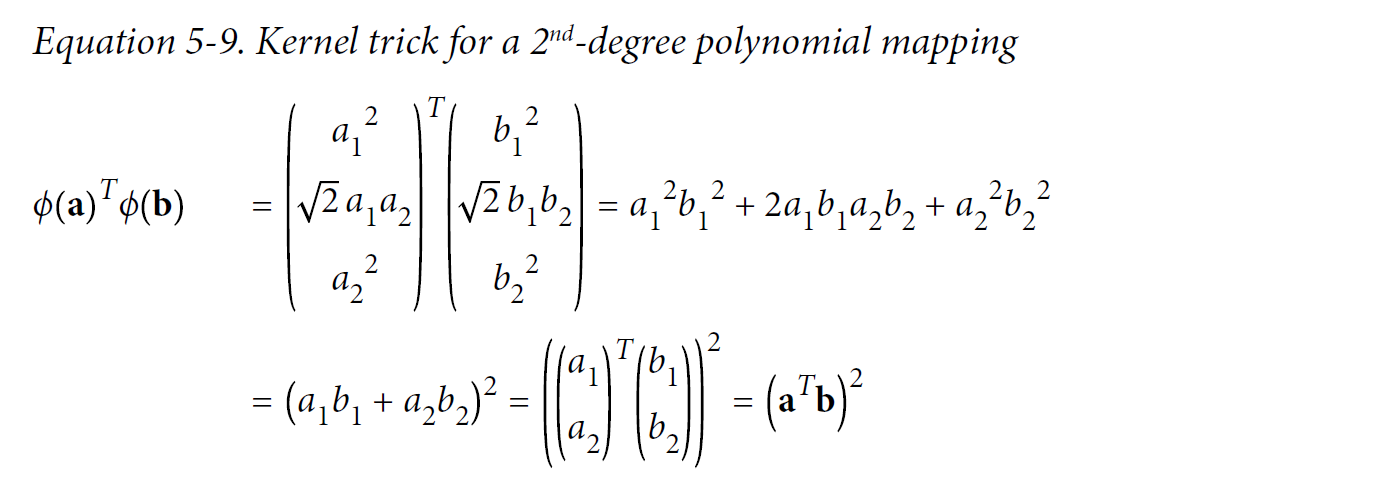

- The dot product of the transformed vectors is equal to the square of
the dot product of the original vectors: $\phi(\mathbf a)^T \phi(\mathbf b) = (\mathbf a^T \mathbf b)^2$.

#### Now here is the key insight:

- If you apply the transformation $\phi$ to all training instances, then the dual problem  will contain the dot product $\phi\left(\mathbf x^{(i)}\right)^T\phi\left(\mathbf x^{(j)}\right)$.
- But if $\phi$ is the 2nd-degree polynomial transformation, then you can replace this dot product of transformed vectors simply by $\left(\mathbf x^{(i)^T}\mathbf x^{(j)}\right)^2$.
- So you don’t actually need to transform the training instances at all: just replace the dot product by its square! The result will be strictly the same as if you went through the trouble of actually transforming the training set then fitting a linear SVM algorithm, but this trick makes the whole process much more computationally efficient. This is the essence of the kernel trick.

- The function $K(\mathbf a, \mathbf b) = (\mathbf a^T \mathbf b)^2$ is called a 2nd-degree polynomial kernel. 
- In Machine Learning, a **kernel** is a function capable of computing the dot product $\phi(\mathbf a)^T \phi(\mathbf b)$ based only on the original vectors $\mathbf a$ and $\mathbf b$, without having to compute (or even to know about) the transformation $\phi$.

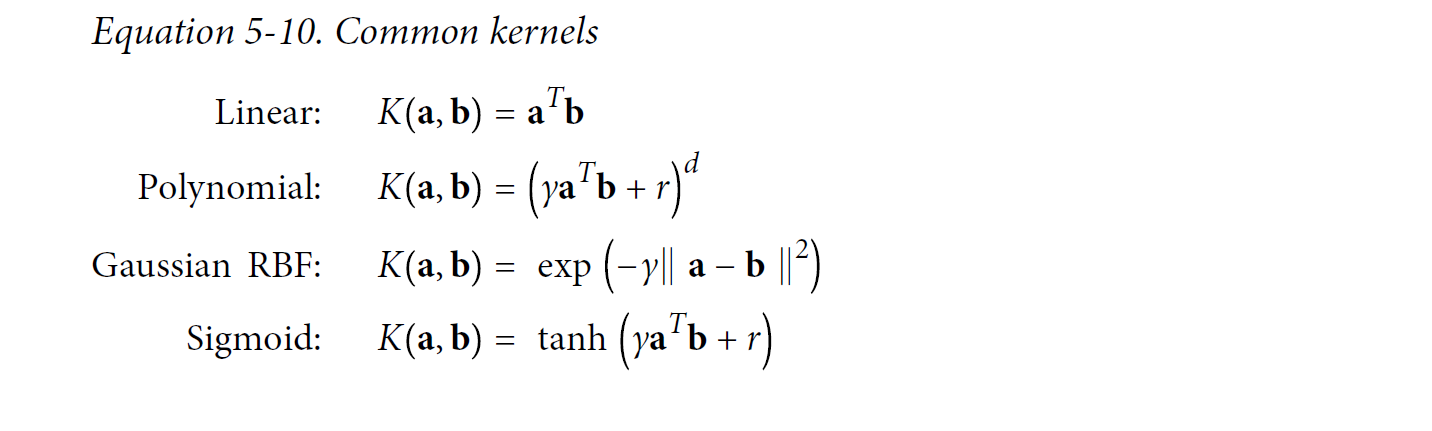

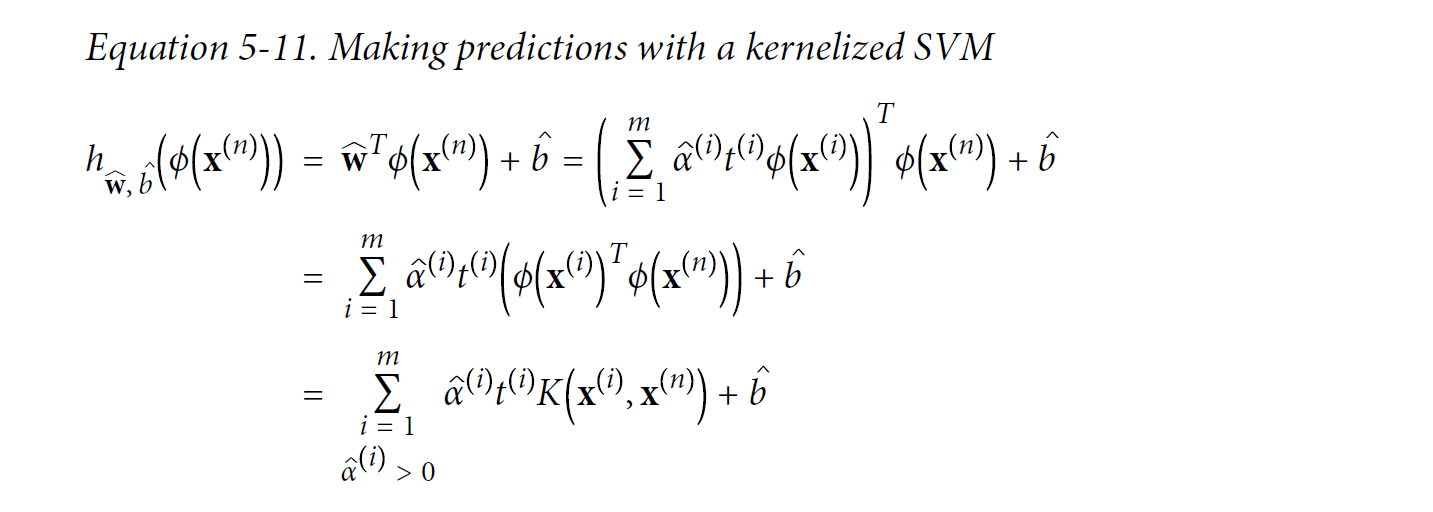

### SVM as a Penalization Method

- It is straightforward to rewrite the minimization problem (just substitute for $\zeta^{(i)}$) as:

$$
\min_{\mathbf w, b} \sum_i \left[1 - y^{(i)}(\mathbf w^T \mathbf x^{(i)}+b)\right]_{+} + \frac{\lambda}{2}\mathbf w^T\mathbf w
$$

Here $\lambda =\frac{1}{C}$ is the penalization parameter (similar to ridge regression) and $[v]_+\equiv \max(v,0)$.

- $\sum_i \left[1 - y^{(i)}(\mathbf w^T \mathbf x^{(i)}+b)\right]_{+}$ is known as the **hinge loss function**.

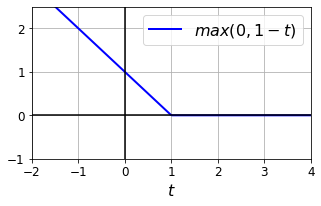

In [32]:
t = np.linspace(-2, 4, 200)
h = np.where(1 - t < 0, 0, 1 - t)  # max(0, 1-t)

plt.figure(figsize=(5,2.8));
plt.plot(t, h, "b-", linewidth=2, label="$max(0, 1 - t)$");
plt.grid(True, which='both');
plt.axhline(y=0, color='k');
plt.axvline(x=0, color='k');
plt.yticks(np.arange(-1, 2.5, 1));
plt.xlabel("$t$", fontsize=16);
plt.axis([-2, 4, -1, 2.5]);
plt.legend(loc="upper right", fontsize=16);
plt.show();

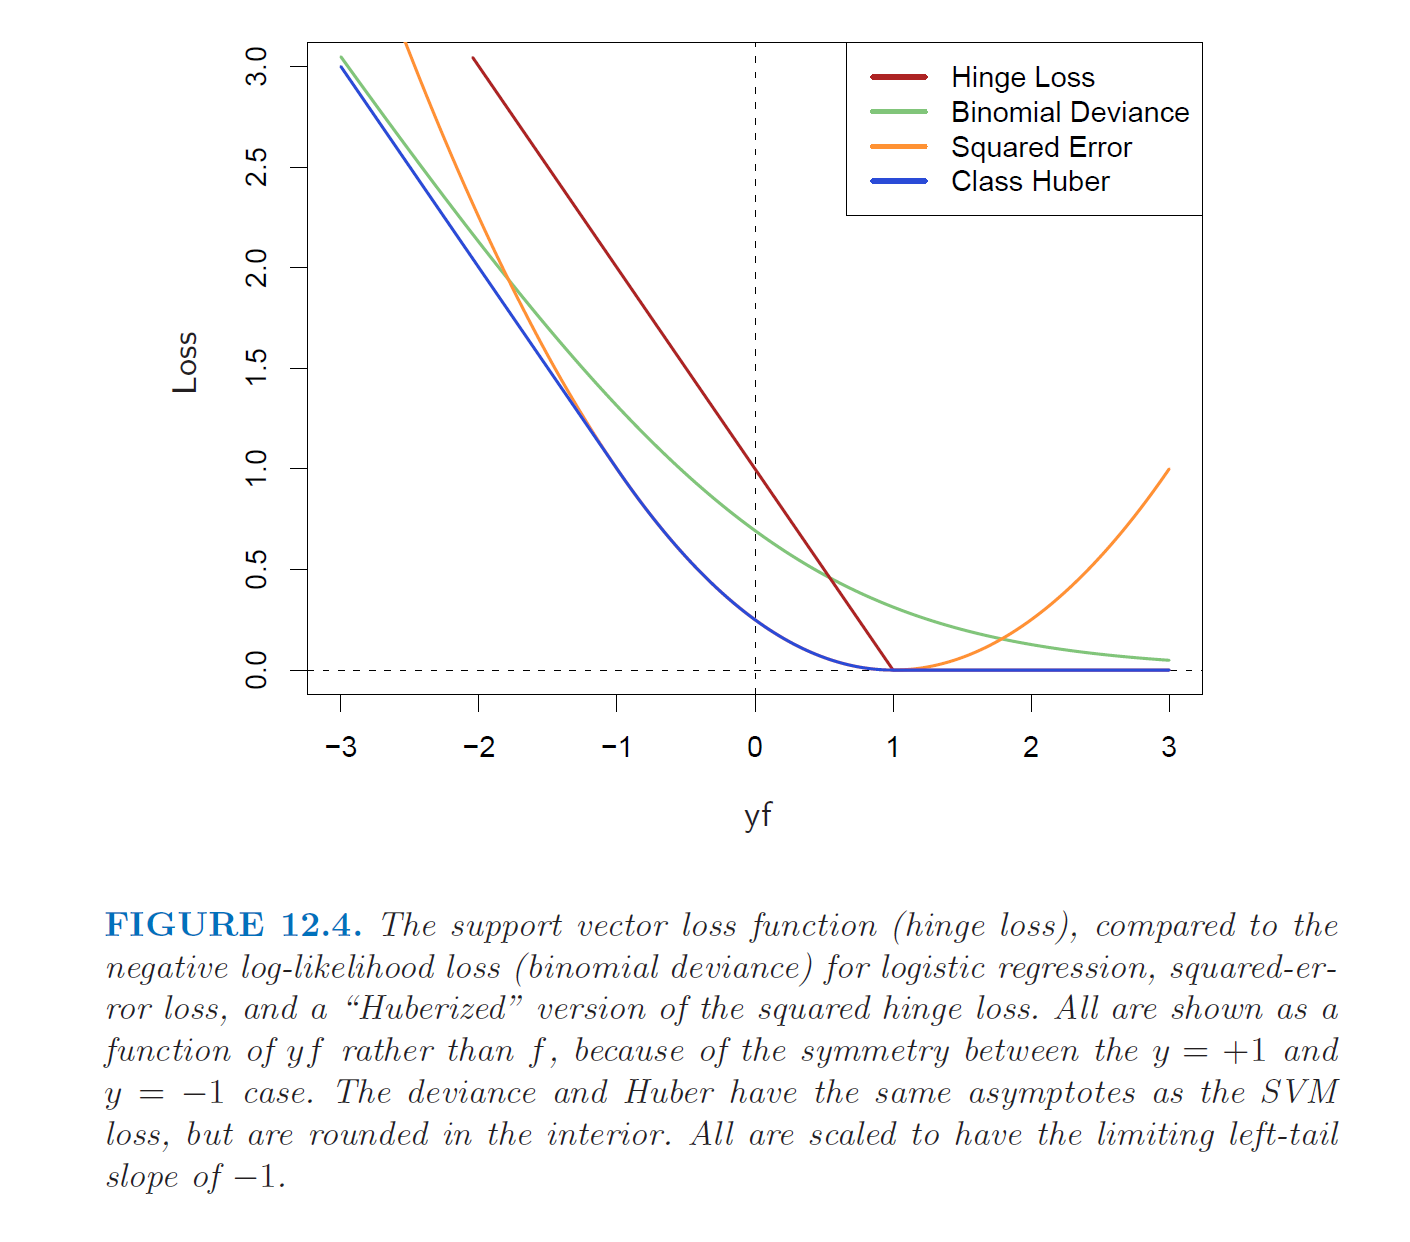